In [1]:
import os
import time
import glob
import pandas as pd
import numpy  as np
import tables as tb

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm     as colormap

from invisible_cities.core.system_of_units import *

from invisible_cities.core.configure   import configure

In [2]:
plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

In [3]:
iconf = configure('isaura $PWD/templates/isauraTemplate.conf'.split())

beersheba_filename = "/tmp/beersheba_events.h5"
isaura_filename    = "/tmp/isaura_events.h5"

In [4]:
deco_ = pd.read_hdf(beersheba_filename, "DECO/Events")

summary_  = pd.read_hdf(isaura_filename, "Summary/Events")
tracking_ = pd.read_hdf(isaura_filename, "Tracking/Tracks")
mchits_   = pd.read_hdf(isaura_filename, "MC/hits")

event_map = pd.read_hdf(isaura_filename, "Run/eventMap")

In [15]:
# choose random event
event_ = event_map.sample(1)

print(event_)

event       = event_.iloc[0].evt_number
nexus_event = event_.iloc[0].nexus_evt

    evt_number  nexus_evt
14          28         14


In [16]:
deco     =     deco_[    deco_.event == event]

summary  = summary_ [ summary_.event == event]
tracking = tracking_[tracking_.event == event]
mchits   = mchits_  [  mchits_.event_id == nexus_event]

In [17]:
summary

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map
14,28,2.405319,-1.0,1,9849,328.784562,-157.337443,667.701956,364.634465,298.675,-172.325,643.878532,337.950753,361.675,-131.325,681.613327,397.597927,False


<IPython.core.display.Javascript object>


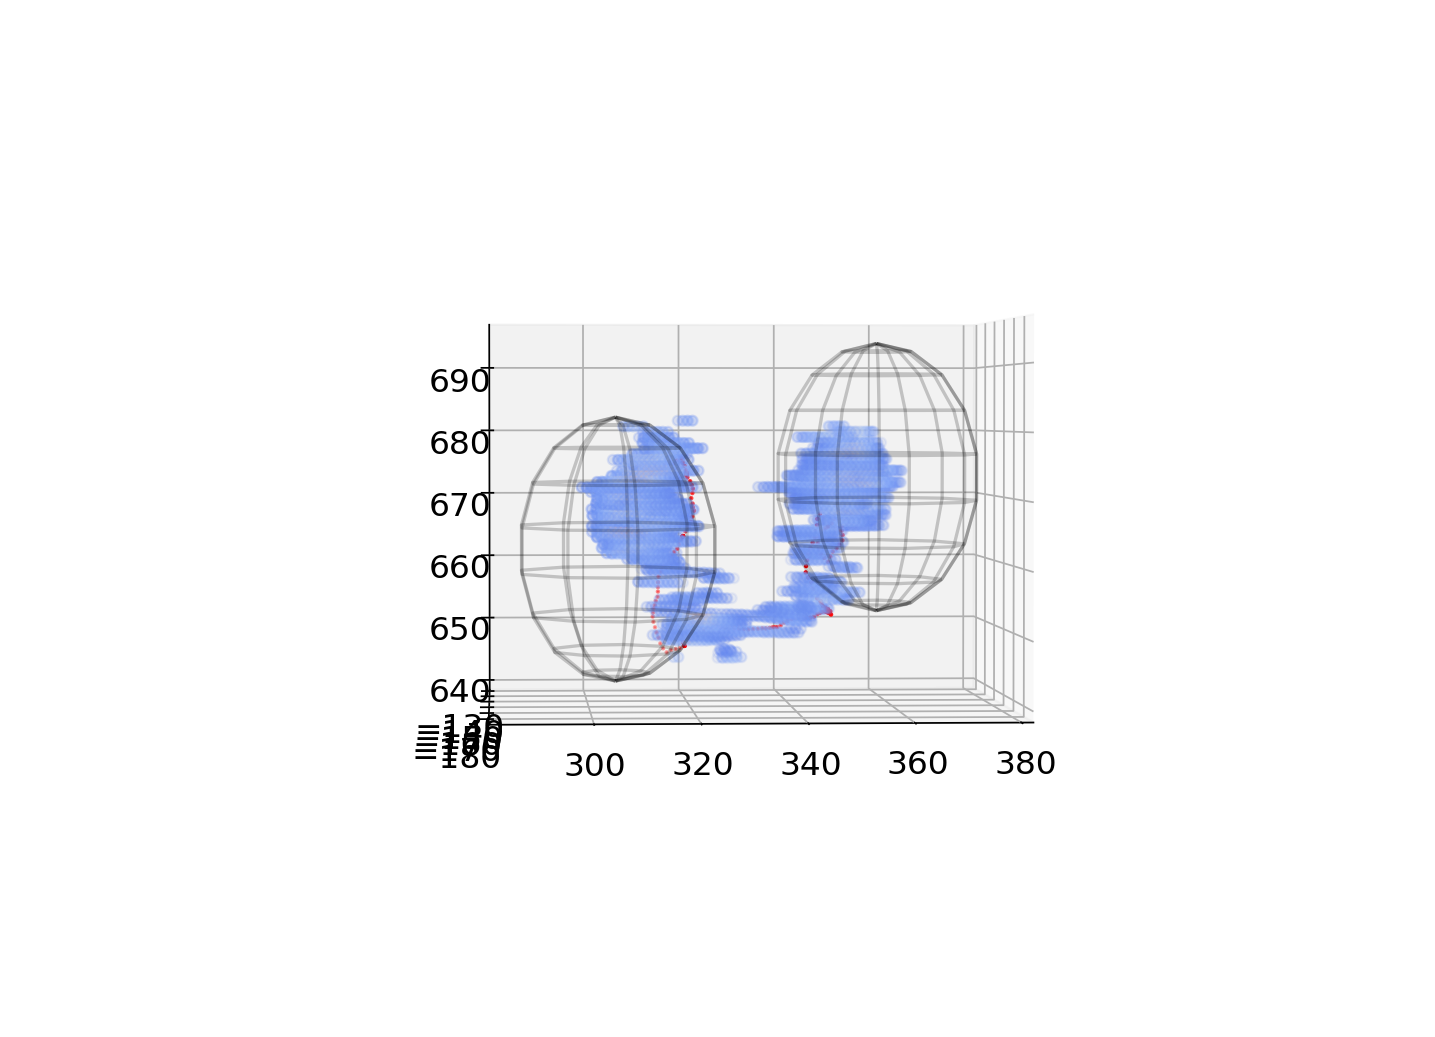

In [18]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(projection='3d')

norm   = colors  .Normalize(vmin=0, vmax=deco.E.max(), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

ax.scatter(deco.X, deco.Y, deco.Z, color=mapper.to_rgba(deco.E), alpha=0.1)

# mchits
ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

# blobs
r = iconf["paolina_params"]["blob_radius"]
phi, theta = np.mgrid[0:2*np.pi:10j, 0:np.pi:10j]
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

# select track with maximum energy
t = tracking.loc[tracking["energy"].idxmax()]
b1_x, b1_y, b1_z = t.blob1_x, t.blob1_y, t.blob1_z
b2_x, b2_y, b2_z = t.blob2_x, t.blob2_y, t.blob2_z

ax.plot_wireframe(x+b1_x, y+b1_y, z+b1_z, alpha=0.2, color="k")
ax.plot_wireframe(x+b2_x, y+b2_y, z+b2_z, alpha=0.2, color="k")

In [19]:
summary

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map
14,28,2.405319,-1.0,1,9849,328.784562,-157.337443,667.701956,364.634465,298.675,-172.325,643.878532,337.950753,361.675,-131.325,681.613327,397.597927,False


# Paolina

In [29]:
# from invisible_cities.types.ic_types import xy
# from invisible_cities.evm            import event_model       as evm
# from invisible_cities.reco           import paolina_functions as plf

# from invisible_cities.cities.esmeralda import types_dict_tracks

# def track_blob_info_creator_extractor(vox_size         : [float, float, float],
#                                       strict_vox_size  : bool                 ,
#                                       energy_threshold : float                ,
#                                       min_voxels       : int                  ,
#                                       blob_radius      : float                ,
#                                       max_num_hits     : int):
#     def create_extract_track_blob_info(hitc):
#         df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
#         if len(hitc.hits) > max_num_hits:
#             return df, hitc, True
#         #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
#         track_hitc = evm.HitCollection(hitc.event, hitc.time)
#         out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
#         if out_of_map:
#             #add nan hits to track_hits, the track_id will be -1
#             track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
#             hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
#             #create new Hitcollection object but keep the name hitc
#             hitc      = evm.HitCollection(hitc.event, hitc.time)
#             hitc.hits = hits_without_nan

#         if len(hitc.hits) > 0:
#             voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, evm.HitEnergy.Ep)
#             (    mod_voxels,
#              dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)
#             tracks           = plf.make_track_graphs(mod_voxels)

#             for v in dropped_voxels:
#                 track_hitc.hits.extend(v.hits)

#             vox_size_x = voxels[0].size[0]
#             vox_size_y = voxels[0].size[1]
#             vox_size_z = voxels[0].size[2]
#             del(voxels)
#             #sort tracks in energy
#             tracks     = sorted(tracks, key=plf.get_track_energy, reverse=True)

#             track_hits = []
#             for c, t in enumerate(tracks, 0):
#                 tID = c
#                 energy = plf.get_track_energy(t)
#                 length = plf.length(t)
#                 numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
#                 numb_of_voxels = len(t.nodes())
#                 numb_of_tracks = len(tracks   )
#                 pos   = [h.pos for v in t.nodes() for h in v.hits]
#                 x, y, z = map(np.array, zip(*pos))
#                 r = np.sqrt(x**2 + y**2)

#                 e     = [h.Ep for v in t.nodes() for h in v.hits]
#                 ave_pos = np.average(pos, weights=e, axis=0)
#                 ave_r   = np.average(r  , weights=e, axis=0)
#                 extr1, extr2 = plf.find_extrema(t)
#                 extr1_pos = extr1.XYZ
#                 extr2_pos = extr2.XYZ

#                 blob_pos1, blob_pos2 = plf.blob_centres(t, blob_radius)

#                 e_blob1, e_blob2, hits_blob1, hits_blob2 = plf.blob_energies_and_hits(t, blob_radius)
#                 overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
#                 list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
#                                 numb_of_hits, numb_of_tracks,
#                                 min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
#                                 *ave_pos, ave_r, *extr1_pos,
#                                 *extr2_pos, *blob_pos1, *blob_pos2,
#                                 e_blob1, e_blob2, overlap,
#                                 vox_size_x, vox_size_y, vox_size_z]

#                 df.loc[c] = list_of_vars

#                 for vox in t.nodes():
#                     for hit in vox.hits:
#                         hit.track_id = tID
#                         track_hits.append(hit)

#             #change dtype of columns to match type of variables
#             df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
#             track_hitc.hits.extend(track_hits)
#         return df, mod_voxels, track_hitc, out_of_map

#     return create_extract_track_blob_info

In [69]:
# from invisible_cities.io.hits_io       import hits_from_df

# paolina_params = dict( vox_size         = [10 * mm, 10 * mm, 10 * mm]
#                      , strict_vox_size  = False
#                      , energy_threshold = 100 * keV
#                      , min_voxels       = 3
#                      , blob_radius      = 21 * mm
#                      , max_num_hits     = 30000)

# paolina_algorithm = track_blob_info_creator_extractor(**paolina_params)

# # deco hits
# DECO = DECO.reindex(columns=CHITS.columns)
# DECO["time"] = 0
# DECO["Ec"]   = DECO["E"]
# DECO["Ep"]   = DECO["E"]
# hitc = hits_from_df(DECO)[DECO["event"].unique()[0]]

# df, voxels, track_hitc, out_of_map = paolina_algorithm(hitc)

In [87]:
# # select track ids with length>0
# df = df[df["length"]>0]
# track_ids = df.trackID.values

# voxels = [voxel for voxel in voxels if voxel.hits[0].track_id in track_ids]

In [88]:
# voxel_pos  = np.array([voxel.pos for voxel in voxels])
# voxel_ene  = np.array([voxel.E   for voxel in voxels])

# lower_corners = np.array([voxel.pos-voxel.size/2. for voxel in voxels])
# upper_corners = np.array([voxel.pos+voxel.size/2. for voxel in voxels])
# corners = np.concatenate((lower_corners, upper_corners))
# corners = np.unique(corners, axis=0)
# x, y, z = np.unique(corners[:, 0]), np.unique(corners[:, 1]), np.unique(corners[:, 2])

# filled, _ = np.histogramdd(voxel_pos, bins=[x, y, z])
# filled  = np.swapaxes(filled, 0, 1).astype(bool)
# x, y, z = np.meshgrid(x, y, z)

In [89]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')

# norm   = colors  .Normalize(vmin=min(voxel_ene), vmax=max(voxel_ene), clip=True)
# mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

# ax.voxels(x, y, z, filled, alpha=0.5, facecolor=mapper.to_rgba(voxel_ene))

# # mchits
# ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

# # blobs
# r = paolina_params["blob_radius"]
# phi, theta = np.mgrid[0:2*np.pi:10j, 0:np.pi:10j]
# x = r*np.sin(theta)*np.cos(phi)
# y = r*np.sin(theta)*np.sin(phi)
# z = r*np.cos(theta)

# # select track with maximum energy
# t = df.loc[df["energy"].idxmax()]
# b1_x, b1_y, b1_z = t.blob1_x, t.blob1_y, t.blob1_z
# b2_x, b2_y, b2_z = t.blob2_x, t.blob2_y, t.blob2_z

# ax.plot_wireframe(x+b1_x, y+b1_y, z+b1_z, alpha=0.2, color="k")
# ax.plot_wireframe(x+b2_x, y+b2_y, z+b2_z, alpha=0.2, color="k")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …